In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml
import importlib

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Section 1. Synthetic Data Experiments

## Section 1.1. DGP with under represented samples on edge
$P(S=1 \mid X) = expit( 0.25 - 2\left((X_0 > 0.5) (X_0 < 1) (X_1 > 0.5) (X_1 < 1)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

### Section 1.1.1. Estimate the target treatment effect using IPW, Outcome Regression and Doubly Robust Estimator

(2.5724337024478223, 0.8056096440614813)
(2.7158190343685957, 0.03578070003649376)
(2.694105549043027, 0.06483286846611812)
2.715024374105188


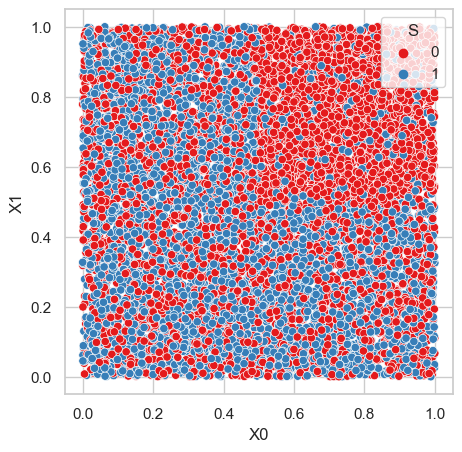

In [421]:
df, Y = strawman_edge.get_data(n=10000, seed=0)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, palette="Set1")
fig.savefig("X0_vs_X1_hue_S.pdf", format="pdf", dpi=600)

atte_sim, atte_se_sim = est.estimate_sim(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_out_reg, atte_se_outreg = est.estimate_out_reg(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_dml, atte_se_dml = est.estimate_dml(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((atte_sim, atte_se_sim))
print((atte_out_reg, atte_se_outreg))
print((atte_dml, atte_se_dml))
print((Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean())

#### Section 1.1.1.a Plotting the Point Estimates and Interval Widths

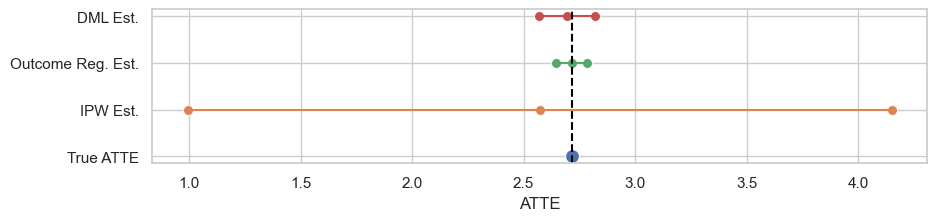

In [422]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 2))
sns.lineplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
)
sns.scatterplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
    s=100,
)
sns.lineplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
)
sns.scatterplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
    s=50,
)

plt.axvline(
    (Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean(), c="black", ls="--"
)

plt.yticks([0, 1, 2, 3], ["True ATTE", "IPW Est.", "Outcome Reg. Est.", "DML Est."])
plt.xlabel("ATTE")
fig.savefig("ATTE_estimates.pdf", format="pdf", dpi=600)

### Section 1.1.2. Learning Optimal $w$ to improve precision of estimate
Here we primarly focus on Doubly Robust Estimator using different strategies to estimate $w(x)$

#### Section 1.1.2.a. Optimization via Linear $w(x)$

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23096563005148485
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
(0.23096563005148485, 0.1433821184430667, 2.9134253675275708, 2.647334831681625)


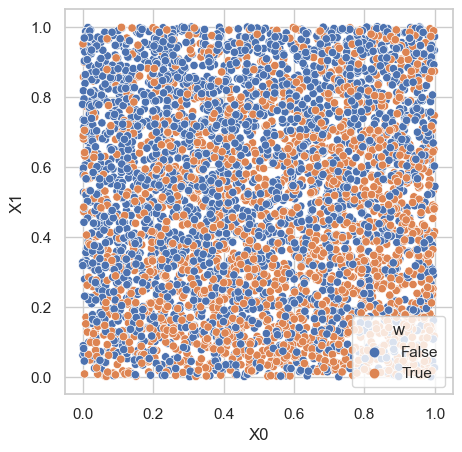

In [425]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.linear_opt(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w")
fig.savefig("linear_opt_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.b. Optimization via Voronoi Sets using K-Means

(0.11919211420918746, 0.14508034690488394, 2.796204025472874, 2.831755070957463)


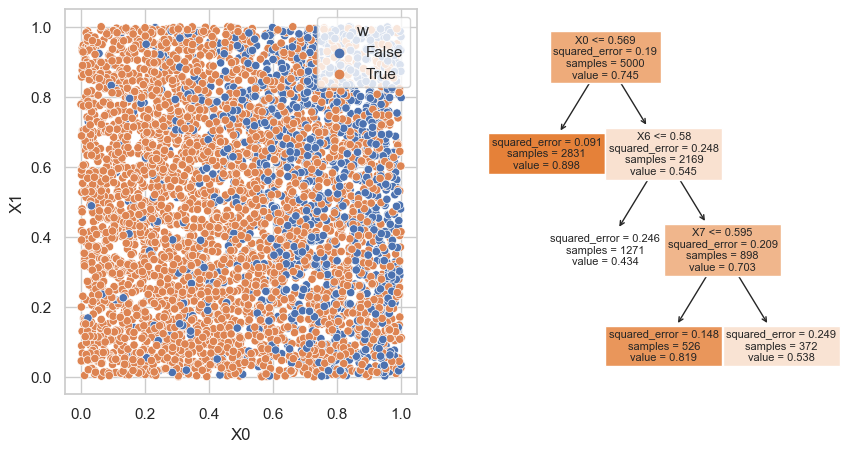

In [427]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.kmeans_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", k=20
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w", ax=ax[0])

plot_tree = tree.plot_tree(
    f,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
    ax=ax[1],
    filled=True,
)
fig.savefig("voronoi_kmeans_opt_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.c. Optimization via (Randomized) Tree $w(x)$

## Split Function Algorithm

The following algorithm outlines the process of the `split` function used in the context of a decision-making process.

```python
function split(split_feature, X, D, parent_loss, depth):
    # Determine the feature fj to split on based on the current depth
    fj = choose(split_feature, depth)

    # Check if this is a base case where we're reaching a leaf node
    if fj equals "leaf":
        # Calculate losses for class 0 and class 1
        losses = { loss(v, X, D) : for v in {0,1} }
        
        # Decide whether to exploit (choose best loss) or explore (random choice)
        w_exploit = argmin(losses)
        w_explore = random.binomial(1, 0.5)
        
        # Introduce randomness in exploration
        explore = random.binomial(1, 0.05)
        
        # Combine exploration and exploitation to decide the final weight
        w = (explore * w_explore) + ((1 - explore) * w_exploit)
        
        # Update the weight in both the global and local datasets
        D.loc[X.index, "w"] = w
        X.loc[X.index, "w"] = w
        
        # Return information about this leaf node
        return {"node": fj, "w": w, "objective": min(losses), "depth": depth}
        
    # Induction case
    else:
        # Calculate the midpoint for the selected feature fj
        cj = midpoint(X[fj])
        
        # Split the dataset into left and right based on the midpoint
        X_left = X.loc[X[fj] <= cj]
        X_right = X.loc[X[fj] > cj]
        
        # Calculate losses for left and right branches
        loss_left = { loss(v, X_left, D) : for v in {0,1} } 
        loss_right = { loss(v, X_right, D) : for v in {0,1} } 
        
        # Find the minimum losses for both left and right branches
        min_loss_left = min(loss_left)
        min_loss_right = min(loss_right)

        # Calculate new loss after the split
        new_loss = ( |X_left| * min_loss_left + |X_right| * min_loss_right) / |X|
        
        # Check if the new split reduces loss compared to parent node
        if new_loss <= parent_loss:
            # Find best actions to take for left and right branches
            w_left = argmin(loss_left)
            w_right = argmin(loss_right)

            # Update weights in both global and local datasets for left branch
            D.loc[X_left.index, "w"] = w_left
            X_left.loc[X_left.index, "w"] = w_left

            # Update weights in both global and local datasets for right branch
            D.loc[X_right.index, "w"] = w_right
            X_right.loc[X_right.index, "w"] = w_right
            
            # Recursively split the left and right branches
            return {
                "node": fj,
                "split": cj,
                "left_tree": split(split_feature, X_left, D, new_loss, depth + 1),
                "right_tree": split(split_feature, X_right, D, new_loss, depth + 1),
                "objective": sqrt(sum(D["vsq"] * D["w"]) / ((sum((1 - D["S"]) * D["w"]) ** 2)))),
                "depth": depth,
            }
        else:
            # If the new split doesn't improve loss, try a different split feature
            split_feature_updated = reduce_weight(fj, copy(split_feature, deep=True))
            return split(split_feature_updated, X, D, parent_loss, depth)


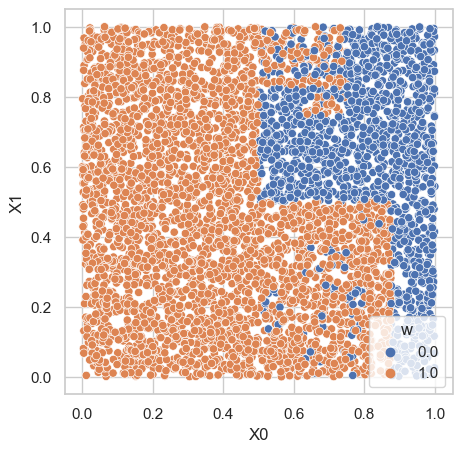

In [429]:
importlib.reload(learn)
D, w_tree, testing_data = learn.tree_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", leaf_proba=0.25, seed=1
)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", data=D, hue="w")
fig.savefig("forest_opt_500trees_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.d. Optimization via (Randomized) Forest $w(x)$ 
Trees with objective worse than baseline are pruned

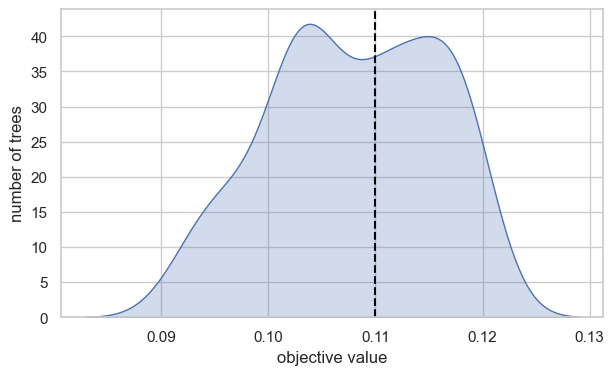

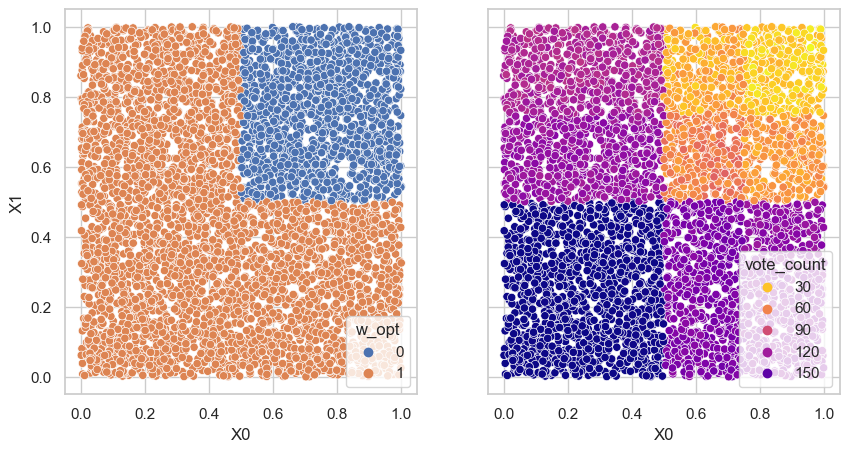

In [430]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=500,
    vote_threshold=1 / 2,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((np.sum((1 - D_forest["S"])) ** 2)))

fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
# sns.histplot(
#     D_forest[[col for col in D_forest.columns if "w_tree" in col]].mean(), ax=ax[0]
# )

sns.kdeplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < 0.12
    ],
    ax=ax,
    fill=True,
)
ax.axvline(0.11, c="black", ls="--")
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")

# D_w_rash = D_forest[["w_tree_%d" % (i) for i in rashomon_set]]
# D_forest["w opt"] = (D_w_rash.mean(axis=1) > (2 / 3)).astype(int)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", hue="w_opt", data=D_rash, ax=ax[0])
sns.scatterplot(
    x="X0", y="X1", hue="vote_count", data=D_rash, ax=ax[1], palette="plasma_r"
)
fig.savefig("forest_opt_500trees_result.pdf", format="pdf", dpi=600)

## Section 1.2. All Linear DGP
$Y(0) = \beta_0^T X + \epsilon$ \
$Y(1) = Y(0) + \beta_1^T X + \epsilon$ \
$P(S=1 \mid X ) = expit( \alpha_0^T X )$

,coef. X0,coef. X1,coef. X2,coef. X3,coef. X4,coef. X5,coef. X6,coef. X7,coef. X8,coef. X9,coef. X10,coef. X11,coef. X12,coef. X13,coef. X14,coef. X15,coef. X16,coef. X17,coef. X18,coef. X19
selection,0.0,0.000000,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0
heterogeneity,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,2.079442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


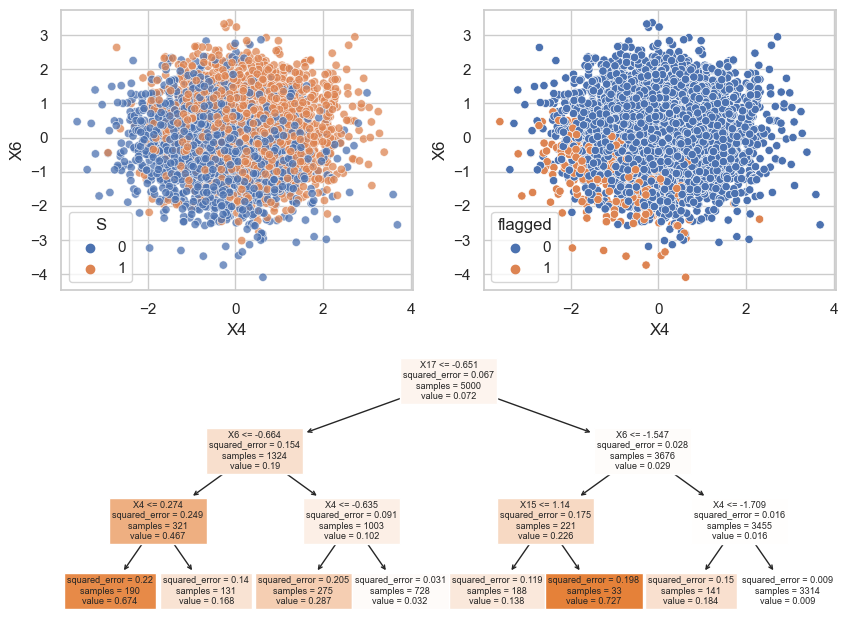

In [431]:
df, Y, coef = all_linear.get_data(n=5000, seed=0)

display(pd.DataFrame(coef, index=["coef. X%d" % (i) for i in range(20)]).T)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")
#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
sns.scatterplot(x="X4", y="X6", hue="S", data=df, alpha=0.75, ax=ax[0, 0])
sns.scatterplot(
    x="X4",
    y="X6",
    hue="flagged",
    data=df_result,
    ax=ax[0, 1],
)

gs = ax[1, 0].get_gridspec()
for axs in ax[1, :]:
    axs.remove()
axbig = fig.add_subplot(gs[1, :])

#### characterization of the under-sampled space
plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=axbig,
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

### Strawman (Hard Mode) Example with under represented samples in the middle
$P(S=1 \mid X) = expit( - 3\left((X_0 > 0.4) (X_0 < 0.6) (X_1 > 0.4) (X_1 < 0.6)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

In [ ]:
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

alpha = [5, 1]
method = "match"
n_neighbors = 100
p = np.inf
characterization_depth = 2
smallest_k = 100

matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df, alpha=alpha, method=method, n_neighbors=n_neighbors, p=p
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(15, 7), ncols=3)
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax[0])
ax[0].add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)

sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax[1],
)
ax[1].add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space

plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax[2],
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

In [ ]:
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax)
ax.add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)

alpha = [100, 0]
method = "match"
n_neighbors = 10
p = np.inf
characterization_depth = 3
smallest_k = 100
matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df,
    alpha=alpha,
    method=method,
    n_neighbors=n_neighbors,
    p=p,
    characterization_depth=characterization_depth,
    smallest_k=smallest_k,
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="X0", y="X1", data=df, alpha=0.75, ax=ax)
sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax,
)
ax.add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax,
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)